In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

import torch
import numpy as np
import random

from model import SmallBasicUNet, BasicUNet, BasicUNetPLUS, CNNLSTM  # Replace with your actual model class name if different
from dataset import DebrisFlowDataset, Augmentation  # Replace with your actual dataset class name if different
from dataset import compute_channel_scaling_params, set_channel_scaling_params_to_dataset
from train import Trainer

from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from viz import ArrayVisualizer

import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)


cpu


In [2]:
viz = ArrayVisualizer()

In [3]:
def set_seed(seed_value):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    random.seed(seed_value)  # Python's built-in random module
    
    # minimise non-deterministic GPU behaviour
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage
set_seed(42) 

In [4]:
# SEQUENCE_LENGTH = 5
# BATCH_SIZE = 32
# LSTM_HIDDEN_SIZE = 64
# LSTM_LAYERS = 2
# NUM_EPOCHS = 10


# # Load the complete dataset
# full_dataset = DebrisFlowDataset(r'C:\Users\thomas.bush\repos\dyna-landslide-surrogate\data_small', sequence_length=SEQUENCE_LENGTH)

# # Split the dataset into training, validation, and test sets
# train_size = int(0.7 * len(full_dataset))
# val_size = int(0.15 * len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# # Create a DataLoader for the training dataset to compute scaling parameters
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# # Compute scaling parameters from the training DataLoader
# min_vals, max_vals = compute_channel_scaling_params(train_loader)

# # Apply the scaling parameters to the original dataset
# # train, val, test are type "subset" when using random_split (which just stores a list of idx)
# set_channel_scaling_params_to_dataset(full_dataset, min_vals, max_vals)

# # Now you can create DataLoaders for training, validation, and testing
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# CHECKING CELLS

Next few cells do some checking. Commented out for now.

In [5]:
# def investigate_dataloader(dataloader, show_sample_data=True):
#     """Investigate a DataLoader by checking various aspects of the loaded data.

#     Args:
#         dataloader (torch.utils.data.DataLoader): The DataLoader to investigate.
#         show_sample_data (bool): Flag to show a sample of the data.

#     Returns:
#         None
#     """
#     for i, data in enumerate(dataloader):
#         # Assuming a (data, target) structure for each batch
#         inputs, targets = data

#         print(f"Batch {i + 1}:")

#         # Check data shapes
#         print(f"  Input batch shape: {inputs.shape}")
#         print(f"  Target batch shape: {targets.shape}")

#         # Check data types
#         print(f"  Input batch dtype: {inputs.dtype}")
#         print(f"  Target batch dtype: {targets.dtype}")

#         # Check for correct batch size
#         print(f"  Batch size: {len(inputs)}")

#         # Optionally, print a sample data (for the first batch only if show_sample_data is True)
#         if show_sample_data and i == 0:
#             print(f"  Input sample data:\n{inputs[0]}")
#             print(f"  Target sample data:\n{targets[0]}")

#         # Stop after the first batch if we only want to show a sample
#         if show_sample_data:
#             break

# def check_data_range(dataloader):
#     """Check if all tensors in the DataLoader have values between 0 and 1.

#     Args:
#         dataloader (torch.utils.data.DataLoader): The DataLoader to check.

#     Returns:
#         bool: True if all values are within the range [0, 1], False otherwise.
#     """
#     for i, data in enumerate(dataloader):
#         # Assuming a (data, target) structure for each batch
#         inputs, targets = data
        
#         # Check the range for inputs and targets
#         if inputs.min() < 0 or inputs.max() > 1 or targets.min() < 0 or targets.max() > 1:
#             return False

#     return True

In [6]:
# investigate_dataloader(train_loader)

In [7]:
# is_data_in_range = check_data_range(test_loader)
# print(f"All tensors are in the range [0, 1]: {is_data_in_range}")

In [8]:
# full_dataset.data_info

In [9]:
# full_dataset.__getitem__(1)[0].shape

# UNET CHECKING

In [10]:
# unet = BasicUNetPLUS(in_channels=3, out_channels=3)

# # Move the model to the device (GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# unet.to(device)

# # Set the model to evaluation mode
# unet.eval()

# # Let's take a batch of data from your train_loader
# # Assuming that the train_loader has been defined and is iterable
# inputs, targets = next(iter(train_loader))

# # Process a single batch, ignoring the sequence length for simplicity
# # Here, we take the first time step of the sequence for demonstration purposes
# input_batch = inputs[:, 0, :, :, :].to(device)  # Shape: [batch_size, channels, height, width]

# # Forward pass to get the output from the model
# with torch.no_grad():  # Disable gradient computation for inference
#     output_batch = unet(input_batch)

# # Move output back to CPU for further operations
# output_batch = output_batch.cpu()

# # output_batch now contains the U-Net predictions for the batch
# print(f'Output batch shape: {output_batch.shape}')

# # Optionally, convert the output tensor to a numpy array if you want to visualize or process it further
# output_batch_np = output_batch.numpy()

# # Now you can visualize or further process the output_batch_np as needed

# viz.plot_array(output_batch[2][2])

# TRAINING


In [11]:
# # Create an instance of your UNet model
# unet = SmallBasicUNet(in_channels=3, out_channels=2)  # Adjust out_channels if necessary

# # Instantiate the CNNLSTMModel using the UNet model
# cnn_lstm_model = CNNLSTM(unet=unet, lstm_hidden_size=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_LAYERS)

# # Define a loss function and an optimizer
# criterion = torch.nn.MSELoss()  # Replace with the loss function appropriate for your task
# optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cnn_lstm_model.to(device)

# # Lists for storing loss values
# train_losses = []
# val_losses = []

# # Training loop
# for epoch in range(NUM_EPOCHS):
#     cnn_lstm_model.train()
#     train_loss = 0.0
#     for input_batch, target_batch in train_loader:
#         # Move tensors to the appropriate device
#         input_batch = input_batch.to(device)
#         target_batch = target_batch.to(device)

#         # Forward pass
#         output_batch = cnn_lstm_model(input_batch)

#         # Compute loss
#         loss = criterion(output_batch, target_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Accumulate the training loss
#         train_loss += loss.item()

#     # Average training loss for the epoch
#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)
#     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {train_loss:.4f}")

#     # Validation loop
#     cnn_lstm_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for input_batch, target_batch in val_loader:
#             # Move tensors to the appropriate device
#             input_batch = input_batch.to(device)
#             target_batch = target_batch.to(device)

#             # Forward pass
#             output_batch = cnn_lstm_model(input_batch)

#             # Compute loss
#             loss = criterion(output_batch, target_batch)

#             # Accumulate the validation loss
#             val_loss += loss.item()

#     # Average validation loss for the epoch
#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)
#     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Validation Loss: {val_loss:.4f}")

# # Save the model (optional, you may want to save the model periodically or after training)
# torch.save(cnn_lstm_model.state_dict(), "cnn_lstm_model.pth")

# # Plotting the training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(NUM_EPOCHS), train_losses, label='Training Loss')
# plt.plot(range(NUM_EPOCHS), val_losses, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [12]:
# # Define the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Set the model to evaluation mode
# cnn_lstm_model.eval()

# # Initialize the test loss
# test_loss = 0.0

# # Test loop
# with torch.no_grad():
#     for input_batch, target_batch in test_loader:
#         # Move tensors to the appropriate device
#         input_batch = input_batch.to(device)
#         target_batch = target_batch.to(device)

#         # Forward pass to get the output from the model
#         output_batch = cnn_lstm_model(input_batch)

#         # Compute loss
#         loss = criterion(output_batch, target_batch)
#         test_loss += loss.item()

# # Calculate average test loss
# test_loss /= len(test_loader)
# print(f"Test Loss: {test_loss:.4f}")

# MAIN.PY MORE FORMAL CONTENT

In [13]:



LEARNING_RATE = 0.001
SEQUENCE_LENGTH = 5
BATCH_SIZE = 32
LSTM_HIDDEN_SIZE = 64
LSTM_LAYERS = 2
NUM_EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the complete dataset
full_dataset = DebrisFlowDataset(r'C:\Users\thomas.bush\repos\dyna-landslide-surrogate\data_small', sequence_length=SEQUENCE_LENGTH)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create a DataLoader for the training dataset to compute scaling parameters
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Compute scaling parameters from the training DataLoader
min_vals, max_vals = compute_channel_scaling_params(train_loader)

# Apply the scaling parameters to the original dataset
# train, val, test are type "subset" when using random_split (which just stores a list of idx)
set_channel_scaling_params_to_dataset(full_dataset, min_vals, max_vals)

# Now you can create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Model, criterion, and optimizer
unet = SmallBasicUNet(in_channels=3, out_channels=2)
cnn_lstm_model = CNNLSTM(unet=unet, lstm_hidden_size=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_LAYERS)
criterion = torch.nn.MSELoss()  # Replace with the loss function appropriate for your task
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE)

# Instantiate augmentation

augmentation = Augmentation()

# Trainer
trainer = Trainer(cnn_lstm_model, criterion, optimizer, device)

# Training and validation
trainer.train(train_loader, val_loader, NUM_EPOCHS)

# Testing
test_loss = trainer.test(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/10 - Train Loss: 0.0103, Validation Loss: 0.0108
Epoch 2/10 - Train Loss: 0.0108, Validation Loss: 0.0083
Epoch 3/10 - Train Loss: 0.0083, Validation Loss: 0.0071
Epoch 4/10 - Train Loss: 0.0071, Validation Loss: 0.0067
Epoch 5/10 - Train Loss: 0.0067, Validation Loss: 0.0058
Epoch 6/10 - Train Loss: 0.0058, Validation Loss: 0.0054
Epoch 7/10 - Train Loss: 0.0054, Validation Loss: 0.0050
Epoch 8/10 - Train Loss: 0.0050, Validation Loss: 0.0046
Epoch 9/10 - Train Loss: 0.0046, Validation Loss: 0.0042
Epoch 10/10 - Train Loss: 0.0042, Validation Loss: 0.0038


TypeError: unsupported format string passed to tuple.__format__

In [14]:
# Access the file information in the full_dataset
def get_data_info(dataset, indices):
    # Retrieve the data info for the given indices
    return [dataset.data_info[idx][0] for idx in indices]

# Retrieve the data info for the training, validation, and test datasets
train_data_info = get_data_info(full_dataset, train_dataset.indices)
val_data_info = get_data_info(full_dataset, val_dataset.indices)
test_data_info = get_data_info(full_dataset, test_dataset.indices)

# Now you can print or inspect the data info
print('Train dataset data info:', train_data_info)
print('Validation dataset data info:', val_data_info)
print('Test dataset data info:', test_data_info)

Train dataset data info: ['00007', '00400', '00295', '00009', '00006', '00003', '00004', '00072', '00010']
Validation dataset data info: ['00184']
Test dataset data info: ['00008', '00005', '00002']


Test Loss: 0.0038


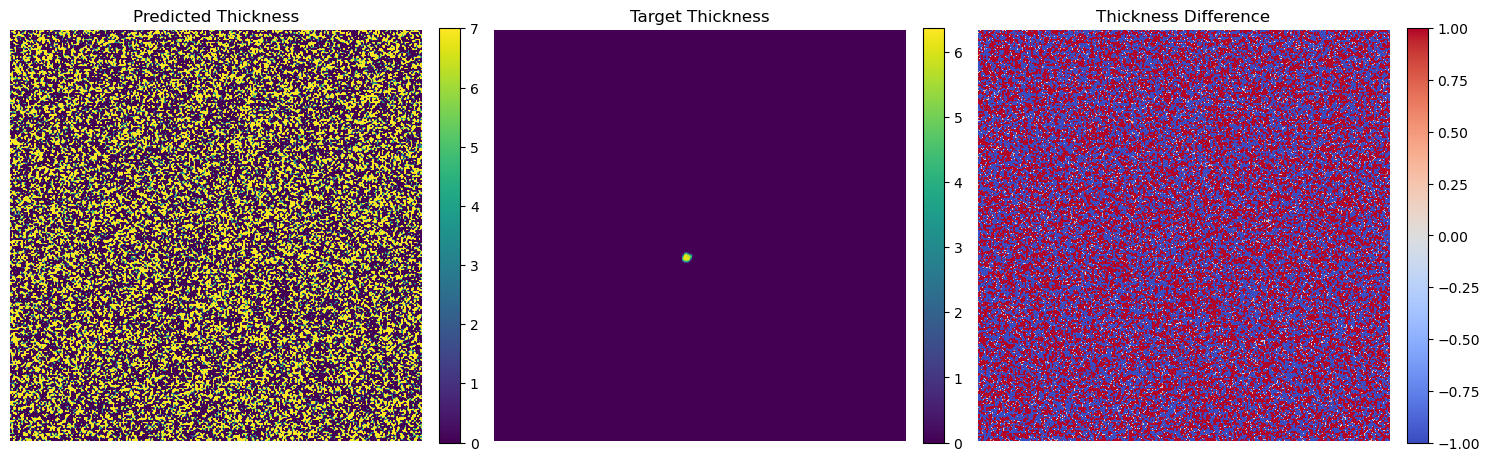

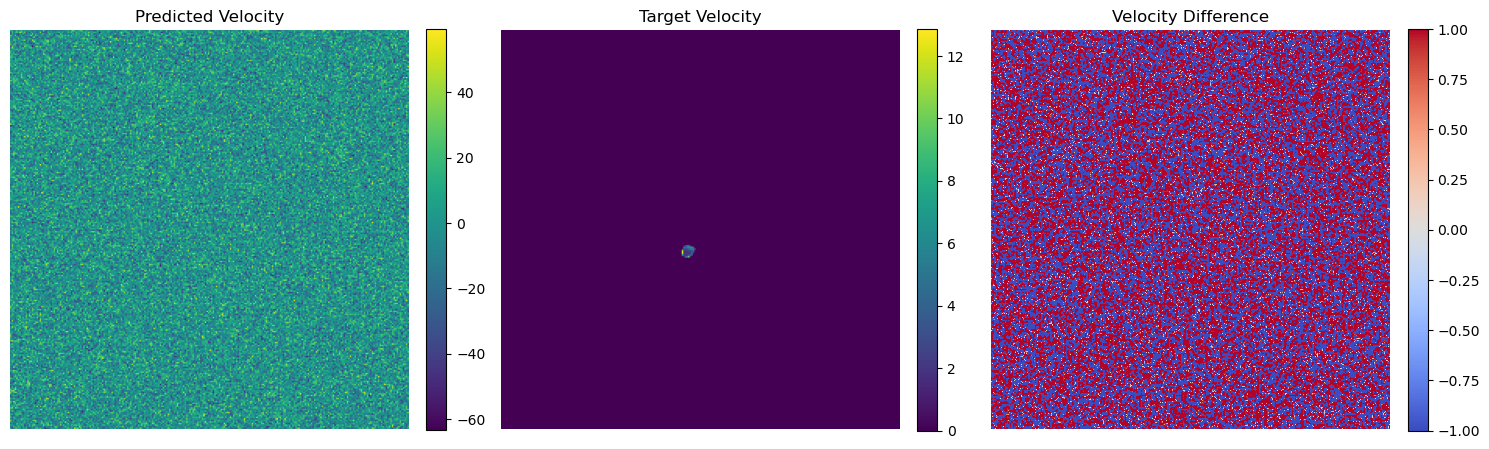

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def inverse_transform(data, min_val, max_val):
    """
    Inverse transform the data from the scaled range back to the original range.
    
    Args:
        data (np.ndarray): The data to inverse transform.
        min_val (float): The minimum value of the original range.
        max_val (float): The maximum value of the original range.
    
    Returns:
        np.ndarray: The inverse transformed data.
    """
    return data * (max_val - min_val) + min_val

def plot_array(array, ax, title, cmap='viridis', vmin=None, vmax=None):
    """
    Plot a 2D array as an image.
    
    Args:
        array (np.ndarray): The 2D array to plot.
        ax (matplotlib.axes.Axes): The matplotlib axes to plot on.
        title (str): The title of the plot.
        cmap (str): The colormap to use (default: 'viridis').
        vmin (float): The minimum value for the colorbar (default: None).
        vmax (float): The maximum value for the colorbar (default: None).
    """
    im = ax.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Testing
test_loss, predicted, target = trainer.test(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Inverse transform the predicted and target values
predicted_thickness_inverse = inverse_transform(predicted[..., 0], min_vals['thickness'], max_vals['thickness'])
target_thickness_inverse = inverse_transform(target[..., 0], min_vals['thickness'], max_vals['thickness'])
predicted_velocity_inverse = inverse_transform(predicted[..., 1], min_vals['velocity'], max_vals['velocity'])
target_velocity_inverse = inverse_transform(target[..., 1], min_vals['velocity'], max_vals['velocity'])

# Plot the predicted thickness, target thickness, and their difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_array(predicted_thickness_inverse, ax=axes[0], title='Predicted Thickness', vmin=0, vmax=7)
plot_array(target_thickness_inverse, ax=axes[1], title='Target Thickness')
plot_array(predicted_thickness_inverse - target_thickness_inverse, ax=axes[2], title='Thickness Difference', cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

# Plot the predicted velocity, target velocity, and their difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_array(predicted_velocity_inverse, ax=axes[0], title='Predicted Velocity')
plot_array(target_velocity_inverse, ax=axes[1], title='Target Velocity')
plot_array(predicted_velocity_inverse - target_velocity_inverse, ax=axes[2], title='Velocity Difference', cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

# THE BELOW WORKED!

In [ ]:
# # Parameters (these would be defined based on your project requirements)
# batch_size = 9
# lstm_hidden_size = 64
# lstm_layers = 2
# num_epochs = 10

# # Create an instance of your UNet model
# unet = SmallBasicUNet(in_channels=3, out_channels=3) 

# # Instantiate the CNNLSTMModel using the UNet model
# cnn_lstm_model = CNNLSTM(unet=unet, lstm_hidden_size=lstm_hidden_size, lstm_layers=lstm_layers)

# # Define a loss function and an optimizer
# criterion = torch.nn.MSELoss()  # Replace with the loss function appropriate for your task
# optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cnn_lstm_model.to(device)

# # Training loop
# for epoch in range(num_epochs):
#     cnn_lstm_model.train()
#     for input_batch, target_batch in train_loader:
#         # Move tensors to the appropriate device
#         input_batch = input_batch.to(device)
#         target_batch = target_batch.to(device)

#         # Forward pass
#         output_batch = cnn_lstm_model(input_batch)

#         # Compute loss
#         loss = criterion(output_batch, target_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Log the loss (You might want to print or log the loss value to monitor training)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

#     # Validation loop (if necessary)
#     cnn_lstm_model.eval()
#     with torch.no_grad():
#         # Validation code goes here
#         pass

#     # Save the model (optional, you may want to save the model periodically or after training)
#     torch.save(cnn_lstm_model.state_dict(), "cnn_lstm_model.pth")